In [ ]:
# data source: https://www.kaggle.com/datasets/paresh2047/uci-semcom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
import ppscore as pps
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from imblearn.over_sampling import SMOTE

In [2]:
# Load data
data = pd.read_csv("../01_data/semi-conductor-signal.csv")
data.insert(0, "label", np.where(data["Pass/Fail"]==-1, 0, 1))
data = data.drop(columns=["Time", "Pass/Fail"])
print(data.shape)
data.head(3)

(1567, 591)


,label,0,1,2,3,4,5,6,7,8,...,580,581,582,583,584,585,586,587,588,589
0,0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,0,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,1,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


In [26]:
print(data["label"].value_counts())
round(data["label"].value_counts()/len(data)*100, 1)
# This is an imbalanced dataset

0    1463
1     104
Name: label, dtype: int64


0    93.4
1     6.6
Name: label, dtype: float64

# Train test split

In [3]:
train, test, y_train, y_test = train_test_split(
    data,
    data['label'],
    test_size=0.2,
    random_state=123,
    stratify=data['label']
)

In [4]:
print(train.index[:10])
print(test.index[:10])

Int64Index([1182, 408, 505, 450, 611, 182, 429, 301, 385, 1222], dtype='int64')
Int64Index([415, 58, 1285, 638, 1308, 394, 919, 542, 541, 1531], dtype='int64')


In [5]:
y_train.to_csv("../03_outputs/01/y_train.csv")
y_test.to_csv("../03_outputs/01/y_test.csv")

# Feature selection
## Remove features with constant values

In [6]:
# Remove features with constant values or 0 variance/std
remove_constant = train.describe().T
remove_constant = remove_constant[remove_constant["std"] == 0]
remove_constant = list(remove_constant.index)
print(f"There are {len(remove_constant)} features with constant values")
remove_constant[:10]

There are 116 features with constant values


['5', '13', '42', '49', '52', '69', '97', '141', '149', '178']

In [7]:
train = train.drop(columns=remove_constant)
test = test.drop(columns=remove_constant)
print(train.shape)
train.head(2)

(1253, 475)


,label,0,1,2,3,4,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
1182,0,3093.16,2631.92,2260.2222,1602.2369,1.210,97.1467,0.1196,1.4146,-0.026,...,0.0038,59.1201,0.4979,0.0113,0.003,2.2646,0.0233,0.0138,0.0038,59.1201
408,0,3017.11,2364.31,2197.2333,1435.1460,0.974,104.8733,0.1226,1.5518,0.013,...,NaN,NaN,0.5013,0.0101,0.003,2.0066,0.0061,0.0141,0.0046,233.2441


## Information gain

In [6]:
importances = mutual_info_classif(
    train.drop(columns=["label"]).fillna(train.drop(columns=["label"]).median()),
    train["label"],
    random_state=123,
)
importances = pd.Series(importances)
importances.index = train.columns[1:]
importances.head(10)

0     0.002426
1     0.000000
2     0.015766
3     0.002899
4     0.000000
6     0.009367
7     0.008656
8     0.000000
9     0.003785
10    0.000000
dtype: float64

In [15]:
np.percentile(importances, 90)

0.013590982456165723

In [16]:
print(f"There {sum(importances < 0.013)} features with weak importances.")

There 422 features with weak importances.


In [18]:
remove_importances = importances[importances < 0.013]
remove_importances = remove_importances.index
remove_importances[:10]

Index(['0', '1', '3', '4', '6', '7', '8', '9', '10', '11'], dtype='object')

In [19]:
train2 = train.drop(columns=remove_importances)
test2 = test.drop(columns=remove_importances)
print(train2.shape)
train2.head(2)

(1253, 53)


,label,2,14,19,40,41,56,59,65,70,...,561,562,563,570,571,573,575,577,583,589
1182,0,2260.2222,9.9116,12.5008,80.44,2.841,0.9341,4.5355,18.6383,605.1609,...,64.0311,264.272,0.5671,531.3036,1.9250,0.2011,0.0619,10.4446,0.0113,59.1201
408,0,2197.2333,6.6757,12.4661,76.57,3.732,0.9266,18.4000,27.6834,631.8009,...,61.2330,253.040,0.7853,534.7936,2.2749,0.2724,0.0733,11.9761,0.0101,233.2441


In [ ]:
train2.to_csv("../03_outputs/01/train2.csv")
test2.to_csv("../03_outputs/01/test2.csv")

## Predictive power

In [10]:
train_pps = pps.matrix(train2)
train_pps.to_csv("../03_outputs/01/ppscore.csv", index=False)

In [23]:
train_pps.head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,label,label,1.0,predict_itself,True,None,0.000000,1.000000,None
1,label,2,0.0,regression,True,mean absolute error,22.308477,22.414962,DecisionTreeRegressor()
2,label,14,0.0,regression,True,mean absolute error,2.233458,2.236626,DecisionTreeRegressor()
3,label,19,0.0,regression,True,mean absolute error,0.078518,0.082153,DecisionTreeRegressor()
4,label,40,0.0,regression,True,mean absolute error,12.025137,16.931438,DecisionTreeRegressor()


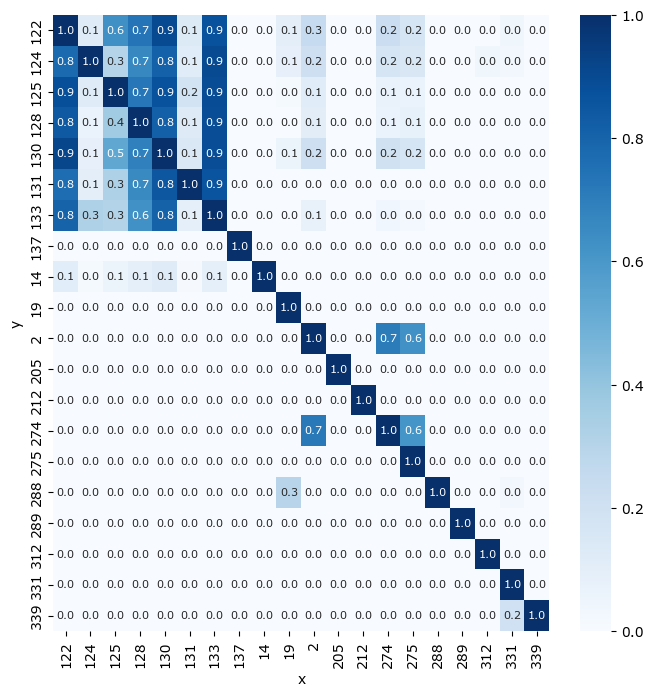

In [24]:
# Visual the partial heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    train_pps[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore').iloc[:20, :20],
    annot=True, fmt=".1f", annot_kws={'size': 8}, cmap="Blues"
)
plt.show()

In [11]:
# Remove features from the highest ppscore
# Count out label and predict_itself
remove_pps_df = train_pps[train_pps["case"]!="predict_itself"]
remove_pps_df = remove_pps_df[((remove_pps_df["x"]!="label") & (remove_pps_df["y"]!="label"))]
# Sort by pps score
remove_pps_df = remove_pps_df.sort_values("ppscore", ascending=False).reset_index(drop=True)

remove_pps_df.head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,416,275,0.996320,regression,True,mean absolute error,5.445857,0.020040,DecisionTreeRegressor()
1,41,40,0.943792,regression,True,mean absolute error,12.025137,0.675909,DecisionTreeRegressor()
2,122,130,0.914263,regression,True,mean absolute error,0.066355,0.005689,DecisionTreeRegressor()
3,130,122,0.899679,regression,True,mean absolute error,0.714839,0.071714,DecisionTreeRegressor()
4,133,124,0.899589,regression,True,mean absolute error,0.089728,0.009010,DecisionTreeRegressor()


In [12]:
score_threshold = 0.7
top_pps = 1.0
while top_pps >= score_threshold: 
    # Get the y of the highest ppscore
    y_remove = remove_pps_df[remove_pps_df.index==remove_pps_df.index.min()]
    top_pps = y_remove["ppscore"].to_list()[0]
    y_remove = y_remove["y"].to_list()[0]
    if top_pps >= score_threshold:
        #Remove if x or y is y_remove
        remove_pps_df = remove_pps_df[((remove_pps_df["x"]!=y_remove) & (remove_pps_df["y"]!=y_remove))]


In [18]:
print(len(remove_pps_df["x"].unique()))
remove_pps_df.head()

33


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
84,415,411,0.690172,regression,True,mean absolute error,0.388848,0.120476,DecisionTreeRegressor()
102,411,415,0.627843,regression,True,mean absolute error,1.784161,0.663989,DecisionTreeRegressor()
123,570,577,0.461081,regression,True,mean absolute error,5.296822,2.854560,DecisionTreeRegressor()
126,19,78,0.433592,regression,True,mean absolute error,0.037990,0.021518,DecisionTreeRegressor()
134,331,70,0.384753,regression,True,mean absolute error,7.442242,4.578815,DecisionTreeRegressor()


In [23]:
remove_pps = remove_pps_df["x"].astype(int).sort_values().unique()
remove_pps = [str(e) for e in list(remove_pps)]
np.array(remove_pps)

array(['14', '19', '41', '59', '65', '70', '78', '84', '92', '137', '212',
       '288', '289', '331', '339', '343', '366', '384', '385', '411',
       '415', '477', '497', '510', '541', '561', '562', '563', '570',
       '571', '577', '583', '589'], dtype='<U3')

In [71]:
train3 = train2[remove_pps]
test3 = test2[remove_pps]
print(train3.shape)
train3.head(3)

(1253, 33)


,14,19,41,59,65,70,78,84,92,137,...,510,541,561,562,563,570,571,577,583,589
1182,9.9116,12.5008,2.841,4.5355,18.6383,605.1609,0.0631,0.1299,-0.0008,108.4,...,70.8333,8.8345,64.0311,264.272,0.5671,531.3036,1.9250,10.4446,0.0113,59.1201
408,6.6757,12.4661,3.732,18.4000,27.6834,631.8009,-0.0454,0.1299,0.0021,50.8,...,26.7658,14.8581,61.2330,253.040,0.7853,534.7936,2.2749,11.9761,0.0101,233.2441
505,10.8990,12.4849,3.194,5.6500,20.0533,614.0309,-0.0640,0.1406,0.0037,66.1,...,33.3709,10.6698,20.7785,NaN,NaN,532.3055,2.0377,13.3898,0.0100,474.0812


## PCA

In [62]:
# Scaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train3)
train_scaled = pd.DataFrame(train_scaled)
test_scaled = scaler.transform(test3)
test_scaled = pd.DataFrame(test_scaled)

# PCA
pca = PCA(random_state=12)
train_pca = pca.fit_transform(train_scaled.fillna(train_scaled.median()))
train_pca = pd.DataFrame(train_pca, index=train3.index)
train_pca.columns = [f"pc_{c}" for c in train_pca.columns]

test_pca = pca.transform(test_scaled.fillna(test_scaled.median()))
test_pca = pd.DataFrame(test_pca, index=test3.index)
test_pca.columns = [f"pc_{c}" for c in test_pca.columns]
train_pca.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_25,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34
1182,-0.977572,-0.976885,0.141798,0.741431,-0.274590,-0.056000,0.261561,1.148271,-0.357836,-1.001233,...,0.739107,-0.825963,-0.534263,-0.048493,0.071467,0.203162,-0.100496,0.081263,-2.299268e-15,-3.031676e-16
408,1.340412,-1.090502,-2.468314,-0.608575,0.086312,-2.802210,-0.001138,0.074416,0.862765,-0.618723,...,-0.285037,-0.202251,0.167145,0.664438,-0.840363,-0.319700,1.092761,0.140705,4.141251e-15,-1.112263e-15
505,1.486722,0.987729,-5.104607,0.350157,0.407229,-0.734791,-0.589613,-0.428006,0.467085,-0.095901,...,0.482617,-0.481063,-0.028079,-0.753408,-0.257586,-0.254240,-0.204995,-0.036898,6.833836e-15,7.140174e-15
450,0.528915,-0.384679,-0.937381,-1.287971,-0.054739,1.364996,0.929028,-0.767006,-0.416673,-1.352159,...,-0.644508,0.208875,-0.042941,0.257939,-0.165644,0.066692,-0.503318,0.012409,7.421931e-16,9.054461e-16
611,0.531616,-1.465972,-0.150026,-1.320305,0.146430,0.299022,-0.468391,-0.068223,0.825023,1.812663,...,-0.130113,-0.294664,2.926323,-0.568779,0.480861,-0.017505,-0.748452,-0.115502,4.814270e-15,-1.054926e-15


In [63]:
# Save the scaler
pickle.dump(scaler, open("../03_outputs/01/scaler_semiconductor.pkl", "wb"))
# loaded_scaler = pickle.load(open("../03_outputs/01/scaler_semiconductor.pkl", "rb"))

# Save the PCA
pickle.dump(pca, open("../03_outputs/01/pca_semiconductor.pkl", "wb"))
# loaded_pca = pickle.load(open("../03_outputs/01/pca_semiconductor.pkl", "rb"))

# Save PCA
train_pca.to_csv("../03_outputs/01/train_pca.csv")
test_pca.to_csv("../03_outputs/01/test_pca.csv")

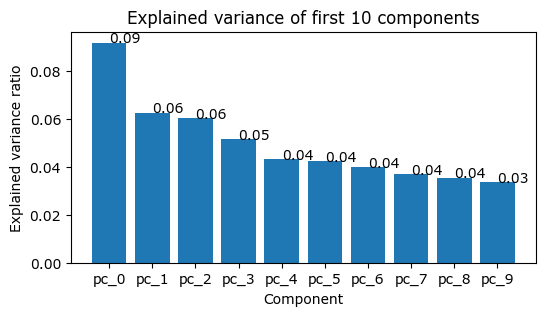

In [69]:
n = 10
plt.figure(figsize=(6, 3))
plt.bar(train_pca.columns[:n], pca.explained_variance_ratio_[:n])
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.title(f'Explained variance of first {n} components')
for i in range(n):
    plt.text(i, pca.explained_variance_ratio_[:n][i], round(pca.explained_variance_ratio_[:n][i], 2))
plt.show()
# There is a weak co-linearity and PCA cannot return principle components with high explained ratio

In [ ]:
# Save
train3.to_csv("../03_outputs/01/train3.csv")
test3.to_csv("../03_outputs/01/test3.csv")

# SMOTE

In [3]:
train3 = pd.read_csv("../03_outputs/01/train3.csv", index_col="Unnamed: 0")
y_train = pd.read_csv("../03_outputs/01/y_train.csv", index_col="Unnamed: 0")

In [4]:
# Apply SMOTE
X_train_smote, y_train_smote = SMOTE(
    sampling_strategy=0.25, k_neighbors=50, random_state=123
).fit_resample(train3.fillna(train3.median()), y_train)

print("Before SMOTE")
print(y_train.value_counts())
print("")
print("SMOTE")
print(y_train_smote.value_counts())

Before SMOTE
label
0        1170
1          83
dtype: int64

SMOTE
label
0        1170
1         292
dtype: int64


In [5]:
# Save
X_train_smote.to_csv("../03_outputs/01/X_train_smote.csv", index=False)
y_train_smote.to_csv("../03_outputs/01/y_train_smote.csv", index=False)